# Run a set of Estimators on a simulated dataset

In [1]:
%matplotlib inline

In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from nimare.transforms import t_to_z

import pymare

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


200611-15:40:51,851 nipype.utils INFO:
	 Running nipype version 1.4.2 (latest: 1.5.0)


INFO:nipype.utils:Running nipype version 1.4.2 (latest: 1.5.0)


In [3]:
def var_to_ci(y, v, n):
    """Convert sampling variance to 95% CI"""
    term = 1.96 * np.sqrt(v) / np.sqrt(n)
    return y - term, y + term

## Simulate some data

In [4]:
n_studies = 40
between_study_var = 400  # population variance
between_study_sd = np.sqrt(between_study_var)
true_effect = 20
sample_sizes = np.round(np.random.normal(loc=50, scale=20, size=n_studies)).astype(int)
within_study_vars = np.random.normal(loc=400, scale=100, size=n_studies)
study_means = np.random.normal(loc=true_effect, scale=between_study_sd, size=n_studies)

sample_sizes[sample_sizes <= 1] = 2
within_study_vars = np.abs(within_study_vars)

In [5]:
# Convert data types and match PyMARE nomenclature
y = study_means
X = np.ones((n_studies))
v = within_study_vars
n = sample_sizes
t = y / np.sqrt(v)
z = np.array([t_to_z(t[i], n[i] - 1) for i in range(n_studies)])
p = stats.norm.sf(abs(z)) * 2

## Plot variable distributions

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


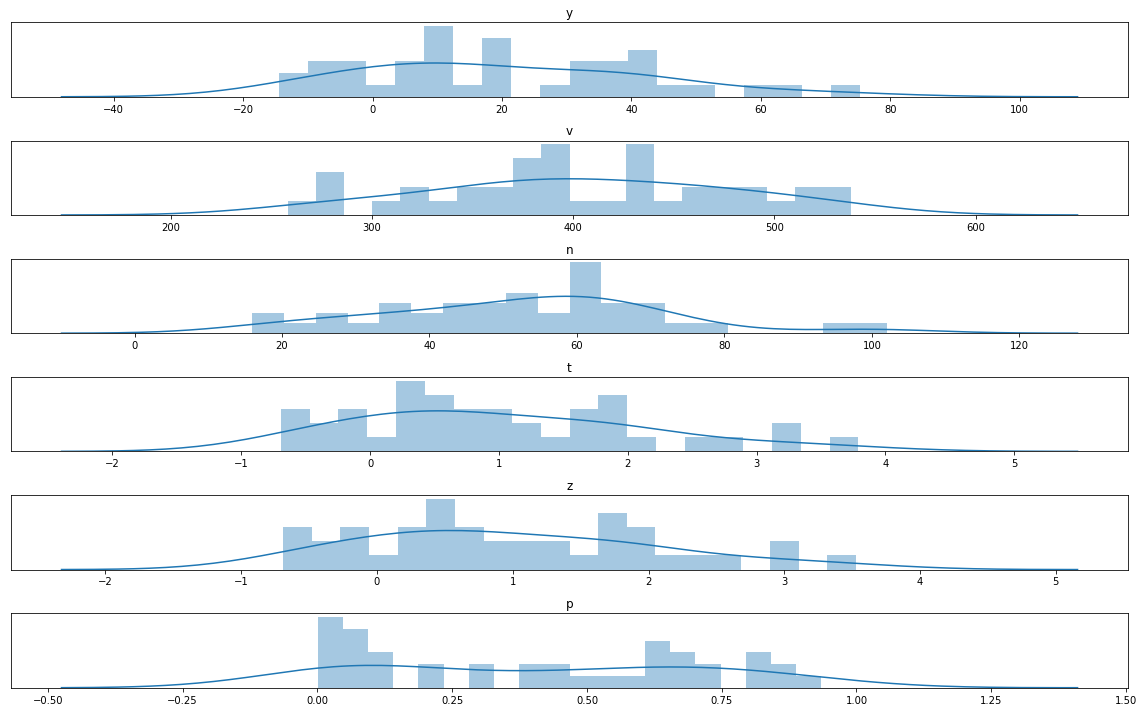

In [6]:
fig, axes = plt.subplots(nrows=6, figsize=(16, 10))
sns.distplot(y, ax=axes[0], bins=20)
axes[0].set_title('y')
sns.distplot(v, ax=axes[1], bins=20)
axes[1].set_title('v')
sns.distplot(n, ax=axes[2], bins=20)
axes[2].set_title('n')
sns.distplot(t, ax=axes[3], bins=20)
axes[3].set_title('t')
sns.distplot(z, ax=axes[4], bins=20)
axes[4].set_title('z')
sns.distplot(p, ax=axes[5], bins=20)
axes[5].set_title('p')
for i in range(6):
    axes[i].set_yticks([])
fig.tight_layout()
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


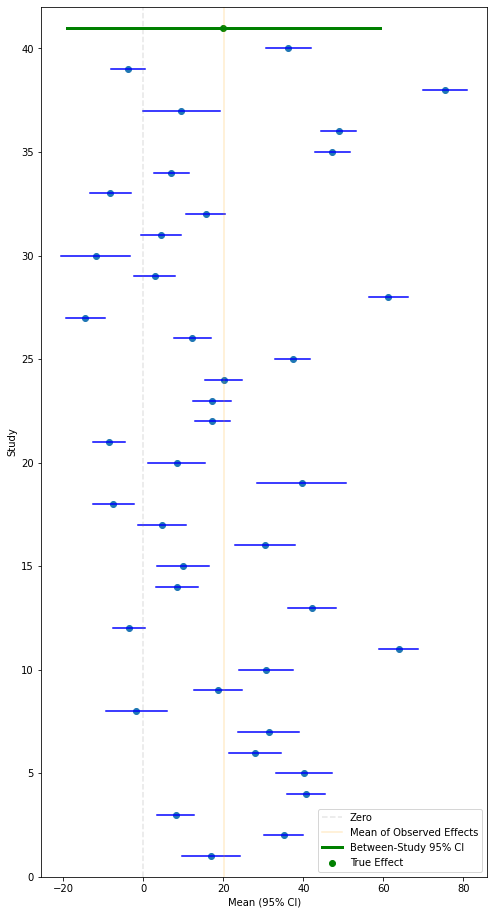

In [7]:
fig, ax = plt.subplots(figsize=(8, 16))
study_ticks = np.arange(n_studies)
# Get 95% CI
lower_bounds, upper_bounds = var_to_ci(y, v, n)
ax.scatter(y, study_ticks+1)
for study in study_ticks:
    ax.plot((lower_bounds[study], upper_bounds[study]), (study+1, study+1), color='blue')
ax.axvline(0, color='gray', alpha=0.2, linestyle='--', label='Zero')
ax.axvline(np.mean(y), color='orange', alpha=0.2, label='Mean of Observed Effects')

# Get 95% CI for true effect
lower_bound, upper_bound = var_to_ci(true_effect, between_study_var, 1)
ax.scatter((true_effect,), (n_studies+1,), color='green', label='True Effect')
ax.plot((lower_bound, upper_bound), (n_studies+1, n_studies+1),
        color='green', linewidth=3, label='Between-Study 95% CI')
ax.set_ylim((0, n_studies+2))
ax.set_xlabel('Mean (95% CI)')
ax.set_ylabel('Study')
ax.legend()
fig.show()

## Fit a model

In [8]:
stouff = pymare.estimators.Stouffers(input='z')
stouff.fit(y=z[:, None])
summary = stouff.summary()
print('z: {}'.format(summary.z))
print('p: {}'.format(summary.p))

z: [6.22789849]
p: [1.]


In [9]:
fisher = pymare.estimators.Stouffers(input='z')
fisher.fit(y=z[:, None])
summary = fisher.summary()
print('z: {}'.format(summary.z))
print('p: {}'.format(summary.p))

z: [6.22789849]
p: [1.]


In [10]:
dset = pymare.Dataset(y=y, X=None, v=v, n=n, add_intercept=True)

In [11]:
dsl = pymare.estimators.DerSimonianLaird()
dsl.fit(dset)
summary = dsl.summary()
print(summary.to_df())

        name   estimate        se   z-score       p-value   ci_0.025  \
0  intercept  20.122277  3.510248  5.732437  9.899805e-09  13.242316   

    ci_0.975  
0  27.002237  


In [12]:
wls = pymare.estimators.WeightedLeastSquares()
wls.fit(dset)
summary = wls.summary()
print(summary.to_df())

        name  estimate       se   z-score       p-value   ci_0.025   ci_0.975
0  intercept  20.04854  3.12256  6.420546  1.357863e-10  13.928435  26.168645


In [13]:
hedge = pymare.estimators.Hedges()
hedge.fit(dset)
summary = hedge.summary()
print(summary.to_df())

        name   estimate        se     z-score  p-value  ci_0.025   ci_0.975
0  intercept  20.114118  0.158114  127.212849      0.0  19.80422  20.424015


In [14]:
vb_ml = pymare.estimators.VarianceBasedLikelihoodEstimator(method='ML')
vb_ml.fit(dset)
summary = vb_ml.summary()
print(summary.to_df())

        name   estimate        se   z-score       p-value   ci_0.025  \
0  intercept  20.122277  3.510247  5.732439  9.899672e-09  13.242319   

    ci_0.975  
0  27.002235  


In [15]:
vb_reml = pymare.estimators.VarianceBasedLikelihoodEstimator(method='REML')
vb_reml.fit(dset)
summary = vb_reml.summary()
print(summary.to_df())

        name   estimate       se   z-score       p-value   ci_0.025   ci_0.975
0  intercept  20.125983  3.53832  5.688005  1.285321e-08  13.191003  27.060963


In [16]:
sb_ml = pymare.estimators.SampleSizeBasedLikelihoodEstimator(method='ML')
sb_ml.fit(dset)
summary = sb_ml.summary()
print(summary.to_df())

        name   estimate        se   z-score       p-value   ci_0.025  \
0  intercept  20.220799  3.449326  5.862246  4.566479e-09  13.460244   

    ci_0.975  
0  26.981354  


In [17]:
sb_reml = pymare.estimators.SampleSizeBasedLikelihoodEstimator(method='REML')
sb_reml.fit(dset)
summary = sb_reml.summary()
print(summary.to_df())

        name   estimate        se   z-score       p-value   ci_0.025  \
0  intercept  20.220837  3.493222  5.788593  7.097866e-09  13.374248   

    ci_0.975  
0  27.067426  
